<div>Kaggle Competition: https://www.kaggle.com/competitions/sharif-ml-1401-pr/leaderboard</div>

In [1]:
!pip install fasttext
!pip install transformers
!pip install evaluate
!pip install --upgrade accelerate
!pip install accelerate -U
import pandas as pd
from sklearn.model_selection import train_test_split
import fasttext
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle
import numpy as np
from time import time
from tqdm import tqdm
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import evaluate
from sklearn.metrics import accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393151 sha256=bb18e10fe4ea7c16492993fe5a376da62bd5c04962292057ff5e9f98e9eadb17
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install gdown
!gdown --id 1BRhlDz-JASvfEljf_XxrL-ZH4gUvOg0v # data-train.csv
# !gdown --id 1jdVascv6Y13CDTCQ04LqpcALqAWTi4a9 # total embeddings (large)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BRhlDz-JASvfEljf_XxrL-ZH4gUvOg0v
To: /content/data-train.csv
100% 8.48M/8.48M [00:00<00:00, 230MB/s]


<div dir="rtl">
<font face="XB Zar" size=5>
</font>
<font face="XB Zar" size=3>
     <br>
در این قسمت از fasttext کمک می‌گیریم تا به یک embedding اولیه برای هر نظر برسیم.
    با استفاده از داده‌هایی که داریم یک مدل fasttext آموزش می دهیم که برای هر توکن یک امبدینگ ۱۰۰تایی بدهد.
    در مرحله‌ی بعد میانگین وزن دار امبدینگ های fasttext
        توکن‌های ورودی
    را بر اساس tfidif آن‌ها محاسبه می کنیم و به امبدینگ نهایی متن می رسیم.
    <br>
    در واقع به عبارت ساده‌تر بر اساس میانگین وزن‌دار که وزن‌های ما tfidf توکن‌ها می‌باشد به امبدینگ نهایی متن بر اساس fasttext می‌رسیم.
    </font>
</div>

<div>We can do this feature engineering but it barely reduce accuracy of kaggle and our test accuracy will be biased so the code below is not appropriate for our task and it is schematic of a kind of feature engineering:</div>

In [ ]:
df = pd.read_csv('data-train.csv')

df = df.drop_duplicates(subset='Phrase')
topic_counts = df['Sentiment'].value_counts()
print(topic_counts)

df['phrase_length'] = df['Phrase'].apply(lambda t: len(t.split()))
rows_to_remove1 = (df['Sentiment'] == 2) & (df['phrase_length'] < 13)
rows_to_remove2 = (df['Sentiment'] == 3) & (df['phrase_length'] < 13)
rows_to_remove3 = (df['Sentiment'] == 1) & (df['phrase_length'] < 13)
rows_to_remove4 = (df['Sentiment'] == 4) & (df['phrase_length'] < 4)
df = df[~rows_to_remove1]
df = df[~rows_to_remove2]
df = df[~rows_to_remove3]
df = df[~rows_to_remove4]

topic_counts = df['Sentiment'].value_counts()
print(topic_counts)

X = df['Phrase'].values
y = df['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

2    79064

3    32714

1    27084

4     9160

0     7026

Name: Sentiment, dtype: int64

4    7301

3    7287

2    7090

0    7026

1    7013

Name: Sentiment, dtype: int64

Train set size: 22858

Validation set size: 5715

Test set size: 7144


<ipython-input-3-58062c9abeb3>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.

  df = df[~rows_to_remove2]

<ipython-input-3-58062c9abeb3>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.

  df = df[~rows_to_remove3]

<ipython-input-3-58062c9abeb3>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.

  df = df[~rows_to_remove4]


<div></div>

In [ ]:
def preprocess_text(text, minimum_length=1, stopword_removal=True, stopwords_domain=[], lower_case=True,
                       punctuation_removal=True):
    """
    preprocess text by removing stopwords, punctuations, and converting to lowercase, and also filter based on a min length
    for stopwords use nltk.corpus.stopwords.words('english')
    for punctuations use string.punctuation

    Parameters
    ----------
    text: str
        text to be preprocessed
    minimum_length: int
        minimum length of the token
    stopword_removal: bool
        whether to remove stopwords
    stopwords_domain: list
        list of stopwords to be removed base on domain
    lower_case: bool
        whether to convert to lowercase
    punctuation_removal: bool
        whether to remove punctuations
    """
    normalized_tokens = word_tokenize(text)

    if stopword_removal:
        stopwords = [x.lower() for x in nltk.corpus.stopwords.words('english')]
        normalized_tokens = [word for word in normalized_tokens if word.lower() not in stopwords]

    if punctuation_removal:
        normalized_tokens = [word for word in normalized_tokens if word not in string.punctuation]

    if lower_case:
        normalized_tokens = [word.lower() for word in normalized_tokens if len(word) > minimum_length]
    else:
        normalized_tokens = [word for word in normalized_tokens if len(word) > minimum_length]

    return normalized_tokens

In [9]:
df = pd.read_csv('data-train.csv')

df = df.drop_duplicates(subset='Phrase')
topic_counts = df['Sentiment'].value_counts()
print(topic_counts)

X = df['Phrase'].values
y = df['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

2    79064
3    32714
1    27084
4     9160
0     7026
Name: Sentiment, dtype: int64
Train set size: 99230
Validation set size: 24808
Test set size: 31010


In [10]:
X[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [11]:
KAGGLE_RUN = 0
COLAB_RUN = 1
if COLAB_RUN:
  PATH = ""
else:
    PATH = "/kaggle/working"

In [12]:
class FastText:

    def __init__(self, preprocessor=None, method='skipgram'):
        self.method = method
        self.model = None
        self.preprocessor = preprocessor

    def train_fasttext(self, corpus_file):
        model = fasttext.train_unsupervised(corpus_file, dim=100, model='skipgram', thread=1)
        return model

    def train(self, texts):
        """
        train the fasttext model and save it into self.model
        Parameters
        ----------
        texts: list of list of str
        """
        with open("corpus.txt", 'w') as file:
            for doc_text in texts:
                file.write(doc_text + '\n')
        self.model = self.train_fasttext("corpus.txt")

    def get_query_embedding(self, query, tf_idf_vectorizer):
        """
        get the embedding of the query. using the tf_idf_vectorizer to get the weights of the words in the query. preprocess the query using self.preprocessor if it is not None
        Parameters
        ----------
        query: str
        tf_idf_vectorizer: TfidfVectorizer
        Returns embedding of the query
        """
        if self.preprocessor is not None:
            query = self.preprocessor(query)

        query_vector = tf_idf_vectorizer.transform([query])

        query_embeddings = []
        total_tf_idf_weight = 0
        feature_names = tf_idf_vectorizer.get_feature_names_out()
        for word_idx in query_vector.indices:
            word = feature_names[word_idx]
            tfidf_weight = query_vector[0, word_idx]
            embedding = self.model.get_sentence_vector(word)
            query_embeddings.append(embedding*tfidf_weight)
            total_tf_idf_weight += tfidf_weight

        if len(query_embeddings) == 0:
           return None
        query_embed = sum(query_embeddings) / total_tf_idf_weight
        return query_embed

    def save_FastText_model(self, path=PATH+'FastText_model.bin'):
        self.model.save_model(path)

    def load_FastText_model(self, path=PATH+"FastText_model.bin"):
            self.model = fasttext.load_model(path)

    def prepare(self, dataset, mode, save=False):
        if mode == 'train':
            self.train(dataset)
        if mode == 'load':
            self.load_FastText_model()
        if save:
            self.save_FastText_model()

In [13]:
FastText_model = FastText()
FastText_model.prepare(np.concatenate((X_train, X_val), axis=0), mode='train', save=True)

In [ ]:
FastText_model = FastText()
FastText_model.prepare(X, mode='load') # X is not important it just load

In [14]:
text = 'filmmaker'
FastText_model.model.get_nearest_neighbors(text)

[(0.9571107625961304, 'Filmmaker'),
 (0.8954034447669983, 'filmmakers'),
 (0.8323990106582642, 'Filmmakers'),
 (0.8219836354255676, 'maker'),
 (0.8183867335319519, 'Widowmaker'),
 (0.8180163502693176, 'filmmaking'),
 (0.7613285779953003, 'moviemaker'),
 (0.7247695326805115, 'film'),
 (0.6816705465316772, 'Whitaker'),
 (0.6722875237464905, 'Baker')]

In [15]:
class TF_IDF:

    def __init__(self):
        self.vectorizer = TfidfVectorizer()

    def fit_vectorizer(self, data):
        """
        fit the vectorizer on the data
        Parameters
        ----------
        data: list of list of str
        """
        self.vectorizer.fit(data)

In [16]:
TF_IDF_model = TF_IDF()
TF_IDF_model.fit_vectorizer(np.concatenate((X_train, X_val), axis=0))

In [17]:
text =  "this movie is awesome"
TF_IDF_model.vectorizer.transform([text])
print(FastText_model.get_query_embedding(text, TF_IDF_model.vectorizer))

[-0.0175683  -0.05075959 -0.04655918  0.02370078  0.17468354 -0.04192305
 -0.07108051 -0.09135047 -0.03040291  0.13150744 -0.00773409  0.03174071
 -0.05552308 -0.01567124  0.01584682  0.07651385 -0.02176052 -0.0043556
 -0.04306502 -0.01256169 -0.02655373  0.04320953  0.04439824  0.02879911
 -0.03671648 -0.0081905   0.0671249  -0.125997   -0.0952822   0.00984657
  0.02211099 -0.02201249 -0.04809056 -0.06255992 -0.1593283  -0.11429734
  0.02620865 -0.03811052  0.01584379  0.11576615 -0.0458205   0.09378083
  0.01835918  0.0577494   0.07291764 -0.04468565  0.01644262  0.13376845
  0.02755518  0.07325929 -0.11079513  0.0185699   0.03593416  0.03250759
  0.00424216 -0.02624241 -0.02313476  0.02592382 -0.04004644  0.00733271
  0.01993223  0.07004878  0.1836217   0.07999543 -0.11743205  0.026768
 -0.00443194  0.11008079  0.01296073 -0.05213154 -0.00800286  0.07914153
 -0.02060326 -0.01564295 -0.12856068  0.12346449  0.10818127 -0.01814982
 -0.05014098 -0.01182928 -0.03022019 -0.02517278  0.03

In [18]:
X_train = [FastText_model.get_query_embedding(X_train[i], TF_IDF_model.vectorizer) for i in range(len(X_train))]
X_val = [FastText_model.get_query_embedding(X_val[i], TF_IDF_model.vectorizer) for i in range(len(X_val))]
X_test = [FastText_model.get_query_embedding(X_test[i], TF_IDF_model.vectorizer) for i in range(len(X_test))]

In [19]:
x_train_bad_data_indices = [index for index, value in enumerate(X_train) if value is None]
x_val_bad_data_indices = [index for index, value in enumerate(X_val) if value is None]
x_test_bad_data_indices = [index for index, value in enumerate(X_test) if value is None]
X_train, y_train = [X_train[i] for i in range(len(X_train)) if i not in x_train_bad_data_indices], [y_train[i] for i in range(len(X_train)) if i not in x_train_bad_data_indices]
X_val, y_val = [X_val[i] for i in range(len(X_val)) if i not in x_val_bad_data_indices], [y_val[i] for i in range(len(y_val)) if i not in x_val_bad_data_indices]
X_test, y_test = [X_test[i] for i in range(len(X_test)) if i not in x_test_bad_data_indices], [y_test[i] for i in range(len(y_test)) if i not in x_test_bad_data_indices]

In [20]:
print(len(X_train), len(X_val), len(X_test))

99126 24786 30977


In [21]:
class PapersDataSet(Dataset):
    def __init__(self, embeddings: list, labels: list):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, index):
        embedding = self.embeddings[index]
        label = self.labels[index]
        return embedding, label

In [22]:
train_dataset = PapersDataSet(X_train, y_train)
val_dataset = PapersDataSet(X_val, y_val)
test_dataset = PapersDataSet(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [23]:
class ClassifierModel(nn.Module):
    def __init__(self, in_features=100, num_classes=5):
        super(ClassifierModel, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, num_classes)
        self.bn4 = nn.BatchNorm1d(num_classes)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        out = self.relu1(self.bn1(self.fc1(x)))
        out = self.relu2(self.bn2(self.fc2(out)))
        out = self.relu3(self.bn3(self.fc3(out)))
        out = self.relu4(self.bn4(self.fc4(out)))
        return out

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ClassifierModel().to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
device

device(type='cuda')

In [26]:
def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False):
    """
    Evaluate the model on the given dataloader. used for validation and test
    Parameters
    ----------
    model: nn.Module
    criterion: nn.Module
    dataloader: torch.utils.data.DataLoader
    test_mode: bool
        If True, the function will print 'Test' instead of 'Validation'
    Returns
    -------
    eval_loss: float
        The loss on the given dataloader
    predicted_labels: list
        The predicted labels
    true_labels: list
        The true labels
    f1_score_micro: float
        The f1 score on the given dataloader
    """
    eval_loss = 0.0
    predicted_labels = []
    true_labels = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    f1_score_micro = f1_score(true_labels, predicted_labels, average='micro')

    return eval_loss, predicted_labels, true_labels, f1_score_micro

In [31]:
"""
Train the model for num_epochs epochs
epoch_true and epoch_all are used to calculate the accuracy.
epoch_true is the number of correct predictions and epoch_all is the total number of predictions in the epoch
"""
num_epochs = 30

train_loss_arr, val_loss_arr = [], []
f1_macro_scores_train, f1_macro_scores_val = [], []
for epoch in range(num_epochs):
    start_time = time()

    train_loss, val_loss = 0, 0
    epoch_all = 0
    epoch_true = 0

    model.train()

    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x, label) in pbar:
            optimizer.zero_grad()
            inputs = x.to(device)
            labels = label.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, y_preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            pbar.set_description(f'Train Loss: {train_loss:.4f}')

    f1_score_micro_train = f1_score(labels.cpu(), y_preds.cpu().tolist(), average="micro")

    model.eval()

    val_loss, predicted_labels, true_labels, f1_score_micro_val = eval_epoch(model, criterion, val_loader)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    f1_macro_scores_train.append(f1_score_micro_train)
    f1_macro_scores_val.append(f1_score_micro_val)

    end_time = time()

    print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')

    print(f"[Epoch {epoch + 1}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}\t F1 score micro: {f1_score_micro_val}")

Train Loss: 90287.7596: 100%|██████████| 3098/3098 [00:20<00:00, 151.73it/s]


Epoch 1 finished in 21.14s
[Epoch 1]	Train Loss: 0.9108	Validation Loss: 0.9748	 F1 score micro: 0.6019123698862261


Train Loss: 90031.4444: 100%|██████████| 3098/3098 [00:17<00:00, 179.92it/s]


Epoch 2 finished in 17.96s
[Epoch 2]	Train Loss: 0.9083	Validation Loss: 0.9717	 F1 score micro: 0.6028403130799646


Train Loss: 89845.4967: 100%|██████████| 3098/3098 [00:17<00:00, 175.42it/s]


Epoch 3 finished in 18.53s
[Epoch 3]	Train Loss: 0.9064	Validation Loss: 0.9698	 F1 score micro: 0.6038892923424514


Train Loss: 89361.3878: 100%|██████████| 3098/3098 [00:17<00:00, 175.25it/s]


Epoch 4 finished in 18.79s
[Epoch 4]	Train Loss: 0.9015	Validation Loss: 0.9717	 F1 score micro: 0.603687565561204


Train Loss: 89120.0997: 100%|██████████| 3098/3098 [00:17<00:00, 172.84it/s]


Epoch 5 finished in 18.67s
[Epoch 5]	Train Loss: 0.8991	Validation Loss: 0.9719	 F1 score micro: 0.6049786169611878


Train Loss: 89146.4863: 100%|██████████| 3098/3098 [00:17<00:00, 177.40it/s]


Epoch 6 finished in 18.20s
[Epoch 6]	Train Loss: 0.8993	Validation Loss: 0.9711	 F1 score micro: 0.6034858387799564


Train Loss: 88772.9784: 100%|██████████| 3098/3098 [00:17<00:00, 178.06it/s]


Epoch 7 finished in 18.14s
[Epoch 7]	Train Loss: 0.8956	Validation Loss: 0.9702	 F1 score micro: 0.6057451787299282


Train Loss: 88401.0888: 100%|██████████| 3098/3098 [00:17<00:00, 178.08it/s]


Epoch 8 finished in 18.13s
[Epoch 8]	Train Loss: 0.8918	Validation Loss: 0.9745	 F1 score micro: 0.607923827967401


Train Loss: 88357.9666: 100%|██████████| 3098/3098 [00:17<00:00, 179.27it/s]


Epoch 9 finished in 18.10s
[Epoch 9]	Train Loss: 0.8914	Validation Loss: 0.9689	 F1 score micro: 0.6078834826111514


Train Loss: 88112.1615: 100%|██████████| 3098/3098 [00:17<00:00, 176.28it/s]


Epoch 10 finished in 18.68s
[Epoch 10]	Train Loss: 0.8889	Validation Loss: 0.9719	 F1 score micro: 0.6038489469862018


Train Loss: 88115.8835: 100%|██████████| 3098/3098 [00:17<00:00, 172.68it/s]


Epoch 11 finished in 18.72s
[Epoch 11]	Train Loss: 0.8889	Validation Loss: 0.9687	 F1 score micro: 0.6048172355361898


Train Loss: 87850.7529: 100%|██████████| 3098/3098 [00:17<00:00, 176.12it/s]


Epoch 12 finished in 18.32s
[Epoch 12]	Train Loss: 0.8863	Validation Loss: 0.9691	 F1 score micro: 0.6064310497861696


Train Loss: 87624.7479: 100%|██████████| 3098/3098 [00:18<00:00, 165.04it/s]


Epoch 13 finished in 19.50s
[Epoch 13]	Train Loss: 0.8840	Validation Loss: 0.9677	 F1 score micro: 0.608085209392399


Train Loss: 87550.5427: 100%|██████████| 3098/3098 [00:17<00:00, 176.95it/s]


Epoch 14 finished in 18.25s
[Epoch 14]	Train Loss: 0.8832	Validation Loss: 0.9713	 F1 score micro: 0.6040103284111998


Train Loss: 87369.1651: 100%|██████████| 3098/3098 [00:17<00:00, 175.79it/s]


Epoch 15 finished in 18.61s
[Epoch 15]	Train Loss: 0.8814	Validation Loss: 0.9653	 F1 score micro: 0.6055434519486808


Train Loss: 87101.1274: 100%|██████████| 3098/3098 [00:17<00:00, 175.03it/s]


Epoch 16 finished in 18.88s
[Epoch 16]	Train Loss: 0.8787	Validation Loss: 0.9684	 F1 score micro: 0.6071572661986605


Train Loss: 87212.6948: 100%|██████████| 3098/3098 [00:17<00:00, 176.48it/s]


Epoch 17 finished in 18.28s
[Epoch 17]	Train Loss: 0.8798	Validation Loss: 0.9647	 F1 score micro: 0.608246590817397


Train Loss: 87080.0392: 100%|██████████| 3098/3098 [00:17<00:00, 176.79it/s]


Epoch 18 finished in 18.26s
[Epoch 18]	Train Loss: 0.8785	Validation Loss: 0.9660	 F1 score micro: 0.6096183329298798


Train Loss: 86776.7248: 100%|██████████| 3098/3098 [00:17<00:00, 177.09it/s]


Epoch 19 finished in 18.24s
[Epoch 19]	Train Loss: 0.8754	Validation Loss: 0.9666	 F1 score micro: 0.607923827967401


Train Loss: 86647.6606: 100%|██████████| 3098/3098 [00:17<00:00, 172.82it/s]


Epoch 20 finished in 18.68s
[Epoch 20]	Train Loss: 0.8741	Validation Loss: 0.9630	 F1 score micro: 0.611595255386105


Train Loss: 86428.4995: 100%|██████████| 3098/3098 [00:17<00:00, 174.19it/s]


Epoch 21 finished in 18.67s
[Epoch 21]	Train Loss: 0.8719	Validation Loss: 0.9668	 F1 score micro: 0.6117162914548535


Train Loss: 86441.5293: 100%|██████████| 3098/3098 [00:17<00:00, 173.40it/s]


Epoch 22 finished in 18.97s
[Epoch 22]	Train Loss: 0.8720	Validation Loss: 0.9662	 F1 score micro: 0.6104655854111192


Train Loss: 86085.2353: 100%|██████████| 3098/3098 [00:17<00:00, 176.17it/s]


Epoch 23 finished in 18.63s
[Epoch 23]	Train Loss: 0.8684	Validation Loss: 0.9675	 F1 score micro: 0.608085209392399


Train Loss: 86178.3797: 100%|██████████| 3098/3098 [00:17<00:00, 173.60it/s]


Epoch 24 finished in 18.60s
[Epoch 24]	Train Loss: 0.8694	Validation Loss: 0.9652	 F1 score micro: 0.6096990236423787


Train Loss: 85819.4190: 100%|██████████| 3098/3098 [00:17<00:00, 175.66it/s]


Epoch 25 finished in 18.39s
[Epoch 25]	Train Loss: 0.8658	Validation Loss: 0.9749	 F1 score micro: 0.6063100137174211


Train Loss: 85971.7796: 100%|██████████| 3098/3098 [00:17<00:00, 173.42it/s]


Epoch 26 finished in 18.58s
[Epoch 26]	Train Loss: 0.8673	Validation Loss: 0.9674	 F1 score micro: 0.6073993383361576


Train Loss: 86206.3905: 100%|██████████| 3098/3098 [00:17<00:00, 175.99it/s]


Epoch 27 finished in 18.31s
[Epoch 27]	Train Loss: 0.8697	Validation Loss: 0.9719	 F1 score micro: 0.6053417251674332


Train Loss: 85615.4800: 100%|██████████| 3098/3098 [00:17<00:00, 179.06it/s]


Epoch 28 finished in 18.01s
[Epoch 28]	Train Loss: 0.8637	Validation Loss: 0.9685	 F1 score micro: 0.6081659001048979


Train Loss: 85798.8087: 100%|██████████| 3098/3098 [00:17<00:00, 176.94it/s]


Epoch 29 finished in 18.23s
[Epoch 29]	Train Loss: 0.8656	Validation Loss: 0.9700	 F1 score micro: 0.6061082869361737


Train Loss: 85436.3804: 100%|██████████| 3098/3098 [00:17<00:00, 176.72it/s]


Epoch 30 finished in 18.25s
[Epoch 30]	Train Loss: 0.8619	Validation Loss: 0.9699	 F1 score micro: 0.6063907044299202


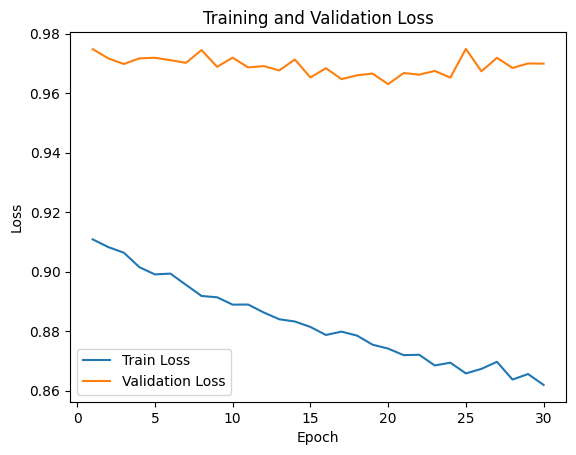

In [32]:
plt.plot(range(1, num_epochs + 1), train_loss_arr, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_arr, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [33]:
model.eval()
eval_loss, predicted_labels, true_labels, f1_score_macro = eval_epoch(model, criterion, test_loader, test_mode=True)

accuracy = accuracy_score(true_labels, predicted_labels)

f1_score_micro = f1_score(true_labels, predicted_labels, average='micro')

confusion_mat = confusion_matrix(true_labels, predicted_labels)

precision_macro = precision_score(true_labels, predicted_labels, average='macro')
recall_macro = recall_score(true_labels, predicted_labels, average='macro')

precision_micro = precision_score(true_labels, predicted_labels, average='micro')
recall_micro = recall_score(true_labels, predicted_labels, average='micro')

print(f"Accuracy: {accuracy:.4f}\n")
print(f"Loss: {eval_loss:.4f}")
print(f"F1-Macro: {f1_score_macro:.4f}")
print(f"F1-Micro: {f1_score_micro:.4f}")
print("Confusion Matrix:")
print(confusion_mat)
print(f"Macro-Average Precision: {precision_macro:.4f}")
print(f"Macro-Average Recall: {recall_macro:.4f}")
print(f"Micro-Average Precision: {precision_micro:.4f}")
print(f"Micro-Average Recall: {recall_micro:.4f}")

Accuracy: 0.6069

Loss: 29809.9774
F1-Macro: 0.6069
F1-Micro: 0.6069
Confusion Matrix:
[[  339   725   244    64    12]
 [  324  2510  2216   379    32]
 [  113  1644 12352  1516    78]
 [   40   489  2561  3002   465]
 [   11    96   225   944   596]]
Macro-Average Precision: 0.5167
Macro-Average Recall: 0.4535
Micro-Average Precision: 0.6069
Micro-Average Recall: 0.6069


<div>accuracy with fasttext and neural network is 60% maximum, because the data is so challenging and sometime hard for experts to predict its sentiment score. but there is a better way to get a high accuracy result and it is pre-trained bert models that find a better embedding for the phrases and we will do this approach next</div>

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('data-train.csv')

df = df.drop_duplicates(subset='Phrase')
topic_counts = df['Sentiment'].value_counts()
print(topic_counts)

X = df['Phrase'].values
y = df['Sentiment'].values

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_train_bert, y_train_bert, test_size=0.2, random_state=42)

print("Train set size:", len(X_train_bert))
print("Validation set size:", len(X_val_bert))
print("Test set size:", len(X_test_bert))

2    79064
3    32714
1    27084
4     9160
0     7026
Name: Sentiment, dtype: int64
Train set size: 99230
Validation set size: 24808
Test set size: 31010


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
MODEL_NAME = "bert-base-uncased"

model_bert = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.n_examples = len(labels)

        print('Using tokenizer on all texts. This can take a while...')
        self.inputs = tokenizer(texts, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt').to(device)

        self.sequence_len = self.inputs['input_ids'].shape[-1]
        print('Texts padded or truncated to %d length!' % self.sequence_len)

        self.inputs.update({'labels':torch.tensor(labels).to(device)})

        return

    def __getitem__(self, idx):
        return {key: self.inputs[key][idx] for key in self.inputs.keys()}

    def __len__(self):
        return self.n_examples

train_dataset = CustomDataset(tokenizer, X_train_bert.tolist(), y_train_bert)
val_dataset = CustomDataset(tokenizer, X_val_bert.tolist(), y_val_bert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 71 length!
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 78 length!


In [ ]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="my_awesome_model_without_freezing_bert_parameter",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.750100,0.739232,0.687601


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=3101, training_loss=0.8022068125784148, metrics={'train_runtime': 1124.4937, 'train_samples_per_second': 88.244, 'train_steps_per_second': 2.758, 'total_flos': 3620613559855260.0, 'train_loss': 0.8022068125784148, 'epoch': 1.0})

<div>As you see, using bert pretrained models for embedding each phrase leads to higher accuracy.</div>